In [1]:
import s3fs
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import boto3
import s3fs
from os.path import dirname, join
from pprint import pprint
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pathlib import Path
import os
import time
import random
from datetime import date
from os.path import exists
import warnings
warnings.filterwarnings('ignore')

In [2]:
fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

### Confirm Existence of .netrc file in your home directory

In [3]:
!cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

1


### Get credentials

In [4]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [5]:
print(f"\nThe current session token expires at {creds['expiration']}.\n")


The current session token expires at 2024-08-17 00:41:03+00:00.



# Define important params

In [6]:
# ECCO Starts on Jan 1, 1992
ECCO_start_time= np.datetime64('1992-09-23')
mean_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/')
alongtrack_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/errors/orbiterror_2cm')

# output directory
output_dir_noerror=Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied')
output_dir=Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied')
output_dir.mkdir(exist_ok=True)

strerror='2 cm'

# Load the ECCO spatial mean 1992-2017

In [7]:
ecco_mean = xr.open_dataset(str(mean_file_dir) + '/ECCO_V4r4_mean_SSH_alllatnosicapplied.nc')
ecco_mean

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 360, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    mean_ssh   (latitude, longitude) float32 1MB ...

# Prepare ECCO Daily SSH dataset

In [8]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"

In [9]:
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

## Make a "direct connection" to the S3 file system

In [10]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [11]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

## Load all of the files for this year from AWS S3 using 'direct connection' and combine into a single xarray DataSet object

### Test

In [12]:
year=1993

ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
paths=[fs.open(f) for f in ECCO_SSH_files]

ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
    )
ECCO_DS_daily.close()

ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)

f=0
# get the date/time associated with this record
rec_time = ECCO_SSH.time.dt.floor("D")[f]

# Count how many days since ecco start time?
delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)

# Determine which GSFC cycle it is 
cycle = int(np.floor(delta_days / 10)+1)
print(cycle)

# Determine which cycle day we're in: cycle day is delta_days mod 10
cycle_day = delta_days % 10

11


In [13]:
# Load the corresponding orbit error data file
filename=str(alongtrack_file_dir) + '/AlongTrack_sample_'+str(cycle).zfill(4)+'_orbiterror.nc'
alongtrack = xr.open_dataset(filename, decode_times=False)
alongtrack

<xarray.Dataset> Size: 20MB
Dimensions:      (i: 602812)
Coordinates:
  * i            (i) int64 5MB 0 1 2 3 4 ... 602807 602808 602809 602810 602811
Data variables:
    time         (i) int64 5MB ...
    y            (i) float32 2MB ...
    x            (i) float32 2MB ...
    orbit_nb     (i) int16 1MB ...
    orbit_error  (i) float64 5MB ...

In [14]:
#Create a dictionary with x,y points for each of the 10 cycle days on the alongtrack sample file
x_track_in_d = {}
y_track_in_d = {}
alongtrack_swath = {}
orbiterror_in_d = {}
tc = 0
all_ins = []
d_total = 0
for d in range(10):
    d_start = d*86400
    d_end = d_start + 86400
    ins = np.where(np.logical_and(alongtrack.time >= d_start, alongtrack.time < d_end))[0]
    orbiterror_in_d[d]=alongtrack.orbit_error[ins] 

    all_ins.append(ins) 
    x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])

    print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')

    tc = tc + len(ins)
    # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
    alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])

cycle day: 0, time_start 0s, time_end 86400s, number of xy points 59523
cycle day: 1, time_start 86400s, time_end 172800s, number of xy points 60551
cycle day: 2, time_start 172800s, time_end 259200s, number of xy points 61022
cycle day: 3, time_start 259200s, time_end 345600s, number of xy points 60572
cycle day: 4, time_start 345600s, time_end 432000s, number of xy points 61407
cycle day: 5, time_start 432000s, time_end 518400s, number of xy points 60498
cycle day: 6, time_start 518400s, time_end 604800s, number of xy points 60235
cycle day: 7, time_start 604800s, time_end 691200s, number of xy points 60658
cycle day: 8, time_start 691200s, time_end 777600s, number of xy points 60949
cycle day: 9, time_start 777600s, time_end 864000s, number of xy points 57397


In [15]:
# sample the ECCO field at the x,y locations for this cycle day 
# search within a 200 km radius for the nearest neighbor.
# (overkill since it's a 1 degree model but just to be safe)
ECCO_at_xy_points =\
    kd_tree.resample_nearest(ECCO_grid_def, \
                             ECCO_SSH[f].values, \
                             alongtrack_swath[cycle_day],\
                             radius_of_influence=200000, fill_value = np.nan)

# make a new DataArray object
ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points+orbiterror_in_d[cycle_day], dims=['i'])
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle':cycle})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since '+str(ECCO_start_time)
ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'
ECCO_at_xy_points_da.cycle.attrs['comment'] = 'Total cycle since '+str(ECCO_start_time)

ECCO_at_xy_points_da.name = 'SSH_at_xy'
ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'
ECCO_at_xy_points_da   

<xarray.DataArray 'SSH_at_xy' (i: 59523)> Size: 476kB
array([        nan,         nan,         nan, ..., -0.06466238,
       -0.06467264, -0.0646829 ])
Coordinates:
  * i           (i) int64 476kB 0 1 2 3 4 5 ... 59518 59519 59520 59521 59522
    time        datetime64[ns] 8B 1993-01-01
    cycle_day   int64 8B 0
    cycle       int64 8B 11
    delta_days  int64 8B 100
    lon         (i) float32 238kB 100.7 100.8 100.8 100.8 ... 53.27 53.34 53.41
    lat         (i) float32 238kB 2.303 2.353 2.402 ... -57.24 -57.2 -57.17
Attributes:
    unit:       cm
    long_name:  orbit error = amplitude * sin(2 pi t/T + phase)
    source:     ECCO V4r4

Text(0.5, 1.0, 'orbit error; 2 cm')

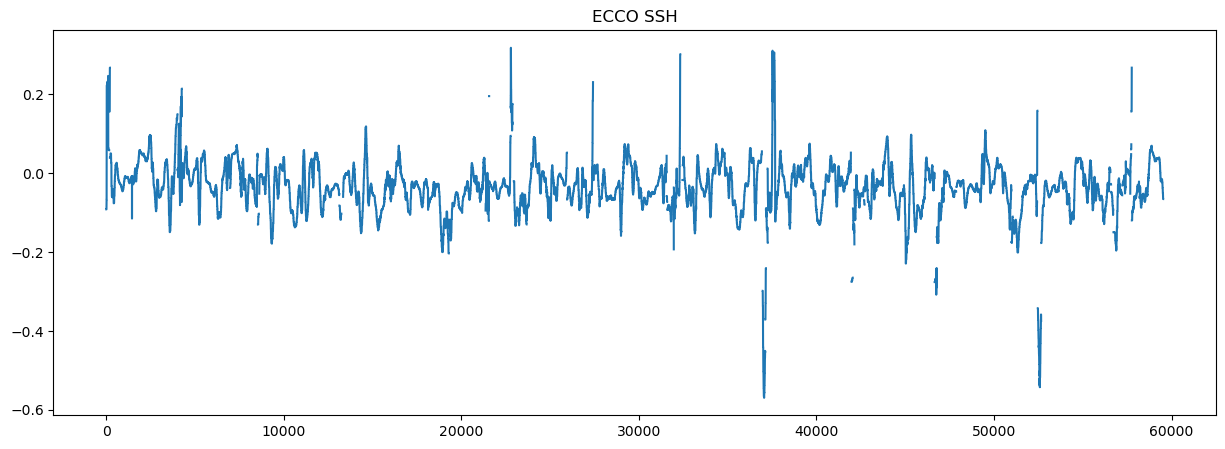

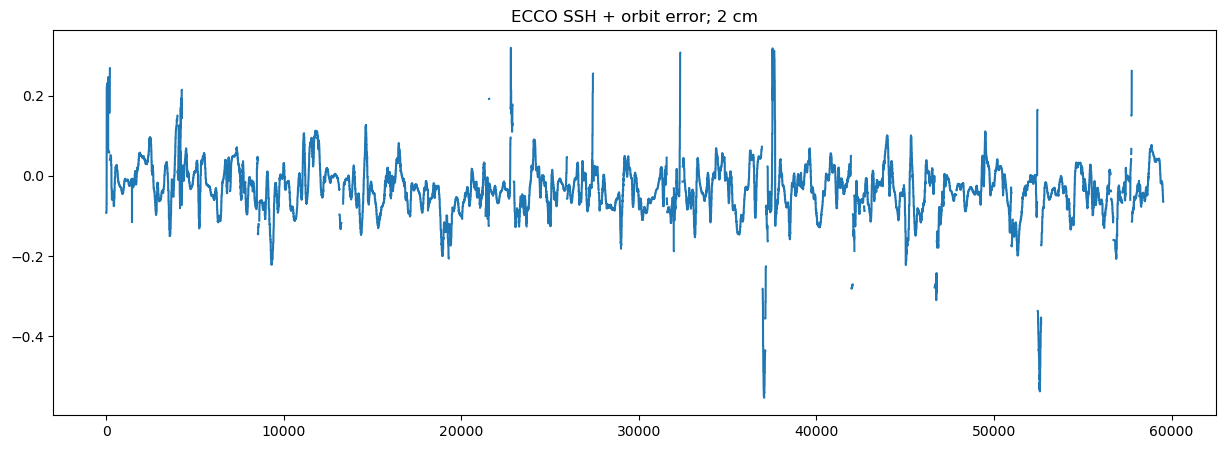

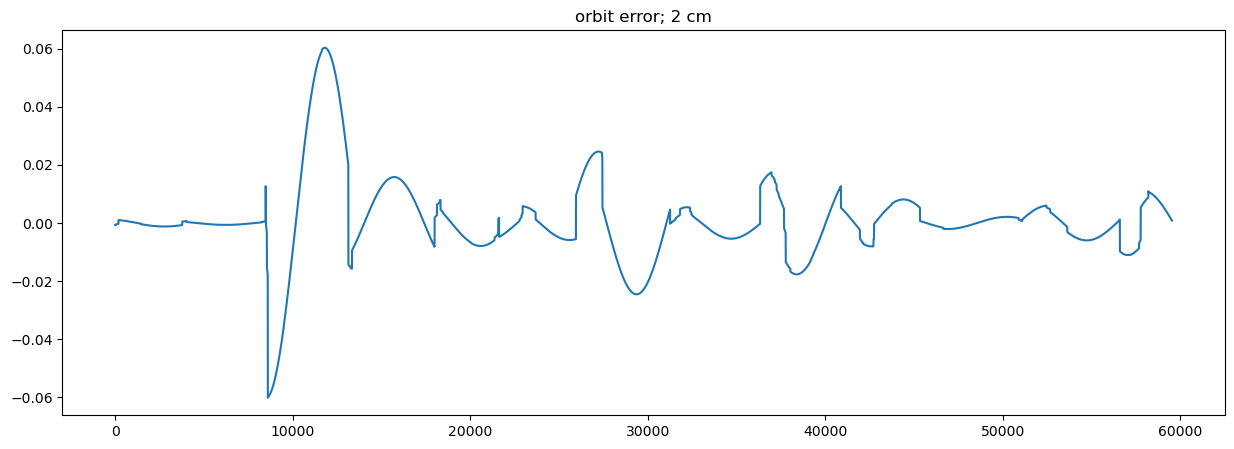

In [16]:
fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy_points)
plt.title('ECCO SSH')

fig = plt.figure(figsize=(15,5))
plt.plot(ECCO_at_xy_points+orbiterror_in_d[cycle_day])
plt.title('ECCO SSH + orbit error; '+strerror)

fig = plt.figure(figsize=(15,5))
plt.plot(orbiterror_in_d[cycle_day])
plt.title('orbit error; '+strerror)

### All Time Series

In [17]:
for year in range(1992,2018):#1992,2018
    
    start_time = time.time()
    ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
    paths=[fs.open(f) for f in ECCO_SSH_files]
    
    ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
    )
    ECCO_DS_daily.close()

    ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
    ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
    ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)
    
    # Loop through all days
    for f in range(len(ECCO_SSH.time)):
        # get the date/time associated with this record
        rec_time = ECCO_SSH.time.dt.floor("D")[f]

        # Count how many days since ecco start time?
        delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)
        if delta_days>=0:

            # Determine which GSFC cycle it is 
            cycle = int(np.floor(delta_days / 10)+1)
            # print(cycle)

            # Determine which cycle day we're in: cycle day is delta_days mod 10
            cycle_day = delta_days % 10

            # Load the corresponding orbit error data file
            filename=str(alongtrack_file_dir) + '/AlongTrack_sample_'+str(cycle).zfill(4)+'_orbiterror.nc'
            if exists(filename):
                alongtrack = xr.open_dataset(filename, decode_times=False)

                #Create a dictionary with x,y points for each of the 10 cycle days on the alongtrack sample file with orbit error    
                x_track_in_d = {}
                y_track_in_d = {}
                alongtrack_swath = {}
                orbiterror_in_d = {}
                tc = 0
                all_ins = []
                for d in range(10):
                    d_start = d*86400
                    d_end = d_start + 86400
                    ins = np.where(np.logical_and(alongtrack.time >= d_start, alongtrack.time < d_end))[0]

                    if len(ins)>0:
                        all_ins.append(ins) 
                        x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])
                        orbiterror_in_d[d] = alongtrack.orbit_error[ins]

                        # print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')

                        tc = tc + len(ins)
                        # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
                        alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])

                # sample the ECCO field at the x,y locations for this cycle day 
                # search within a 200 km radius for the nearest neighbor.
                # (overkill since it's a 1 degree model but just to be safe)
                try:
                    ECCO_at_xy_points =\
                        kd_tree.resample_nearest(ECCO_grid_def, \
                                                 ECCO_SSH[f].values, \
                                                 alongtrack_swath[cycle_day],\
                                                 radius_of_influence=200000, fill_value = np.nan)

                    # make a new DataArray object
                    ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points+orbiterror_in_d[cycle_day], dims=['i'])
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle':cycle})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
                    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
                    ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since '+str(ECCO_start_time)
                    ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'
                    ECCO_at_xy_points_da.cycle.attrs['comment'] = 'Total cycle since '+str(ECCO_start_time)

                    ECCO_at_xy_points_da.name = 'SSH_at_xy'
                    ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'
                    ECCO_at_xy_points_da   

                    # Save to Disk
                    new_fname = 'ECCO_V4r4_alongtrack_SSH_' + str(rec_time.values).split('T')[0] + '_orbiterror.nc'
                    ECCO_at_xy_points_da.to_netcdf(output_dir / new_fname)
                except:
                    print('no data for '+str(rec_time.values).split('T')[0])
    
    print(year, time.time() - start_time, cycle)

2005 147.65103316307068 485
2007 147.282452583313 558
2008 149.12358975410461 595
2009 151.88728165626526 631
2010 147.35834503173828 668
2011 144.47967267036438 704
2012 146.98106217384338 741
2013 148.1064577102661 777
2014 147.6083641052246 814
2015 146.00589203834534 850
2016 147.9434642791748 887
2017 152.4413402080536 924


# Plot 10 days of along track SSH

In [18]:
year=1992
ECCO_alongtrack_files = np.sort(list(output_dir.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '*nc')))
ECCO_alongtrack_files_noerror = np.sort(list(output_dir_noerror.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '*nc')))

In [19]:
tmp = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp.append(xr.open_dataset(ECCO_alongtrack_files[d]))
    print(ECCO_alongtrack_files[d])

/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-26_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-27_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-28_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-29_orbiterror.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_outpu

In [20]:
tmp2 = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp2.append(xr.open_dataset(ECCO_alongtrack_files_noerror[d]))
    print(ECCO_alongtrack_files_noerror[d])

/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-26.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-27.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-28.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-29.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-30.nc
/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-10-01.nc
/home/jpluser/ECCO_

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


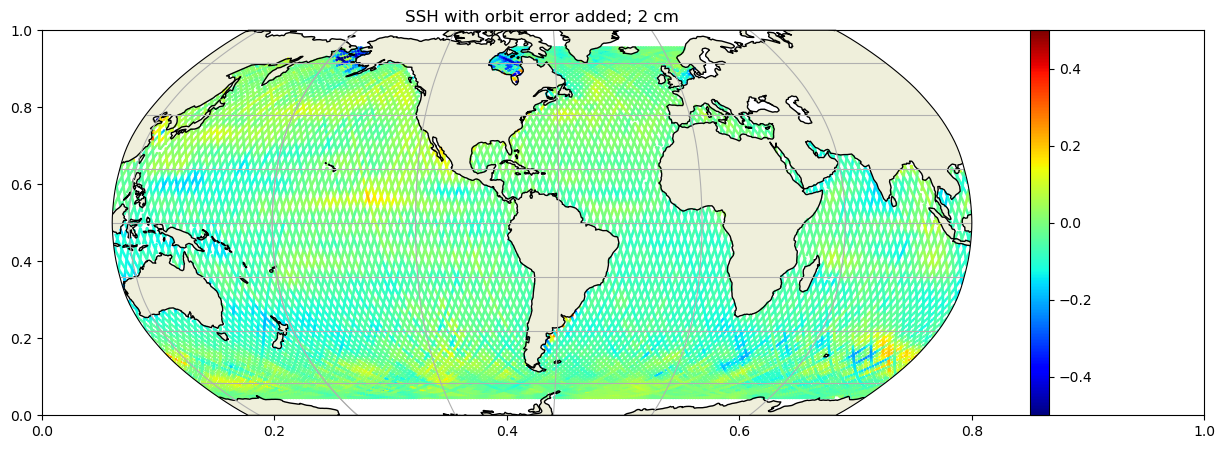

In [21]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')
    ax.set_title('SSH with orbit error added; '+strerror)
plt.colorbar(p)

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


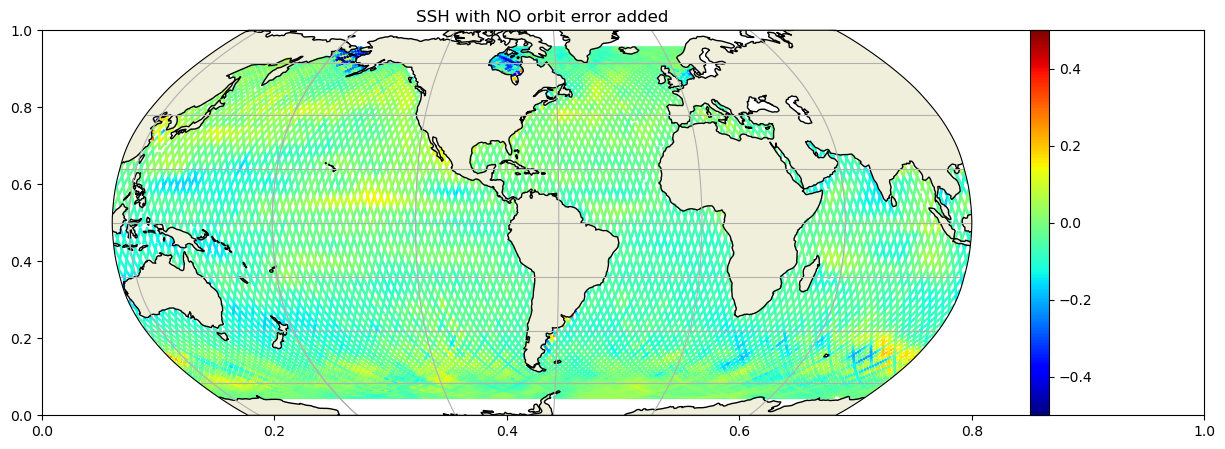

In [22]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp2[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')  
    ax.set_title('SSH with NO orbit error added')
plt.colorbar(p)

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9
adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


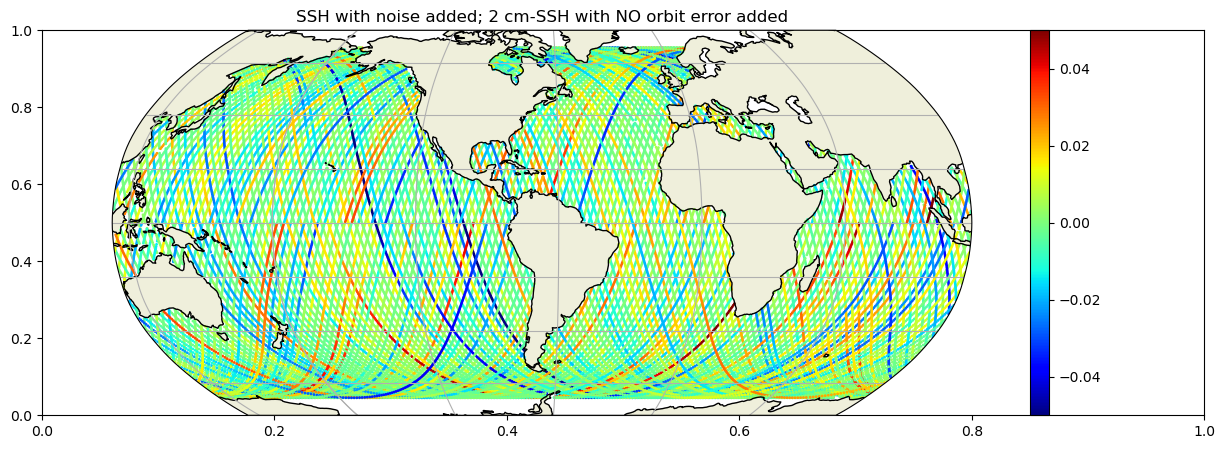

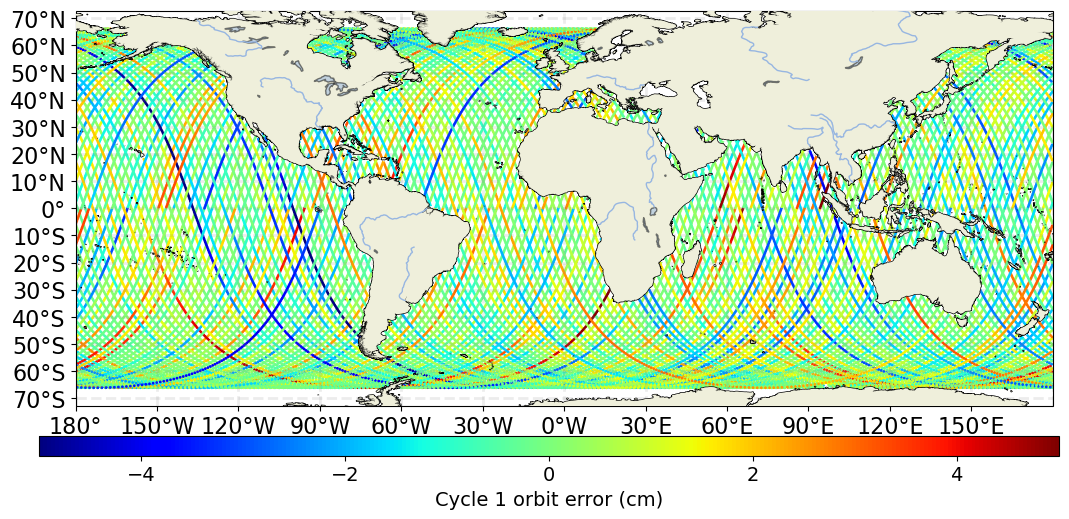

In [23]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy2 = tmp2[d].SSH_at_xy
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy2[::kk]-ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.05,vmax=0.05, cmap='jet')
    ax.set_title('SSH with noise added; '+strerror+'-SSH with NO orbit error added')
plt.colorbar(p)


lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

import cartopy

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both', which='major', labelsize=16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl


kk=12

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
for d in range(10):
    ECCO_at_xy2 = tmp2[d].SSH_at_xy
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')
    pp = plt.scatter(ECCO_at_xy.lon[::kk],ECCO_at_xy.lat[::kk],c=(ECCO_at_xy2[::kk]-ECCO_at_xy[::kk])*100, s=1,cmap=palette,vmin=-5,vmax=5,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('Cycle 1 orbit error (cm)',fontsize=14)
h.ax.tick_params(labelsize=14)
plt.savefig(fig_dir / 'map_cycle1_orbiterror_nosicapplied.png',dpi=200,transparent=False,facecolor='white')